<a href="https://colab.research.google.com/github/ShevchenkOksana/MNIST/blob/main/MNIST_classification_using_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# clean cache
!rm -rf t*.gz

# download dataset
!echo "Loadig..."
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

Loadig...
--2023-12-03 05:18:54--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2023-12-03 05:18:55 (94.4 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-12-03 05:18:55--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[=

In [ ]:
import os
import sys
import gzip
import struct
from typing import List

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [ ]:
def read_images_archive(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n * rows * columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_labels_archive(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

In [ ]:
with gzip.open("train-images-idx3-ubyte.gz", "rb") as fp:
    train_images = read_images_archive(fp)
    print(f"Loaded training images with shape {train_images.shape}!")

with gzip.open("train-labels-idx1-ubyte.gz", "rb") as fp:
    train_labels = read_labels_archive(fp)
    print(f"Loaded training labels with shape {train_labels.shape}!")

with gzip.open("t10k-images-idx3-ubyte.gz", "rb") as fp:
    test_images = read_images_archive(fp)
    print(f"Loaded test images with shape {test_images.shape}!")

with gzip.open("t10k-labels-idx1-ubyte.gz", "rb") as fp:
    test_labels = read_labels_archive(fp)
    print(f"Loaded test labels with shape {test_labels.shape}!")

Loaded training images with shape (60000, 28, 28)!
Loaded training labels with shape (60000,)!
Loaded test images with shape (10000, 28, 28)!
Loaded test labels with shape (10000,)!


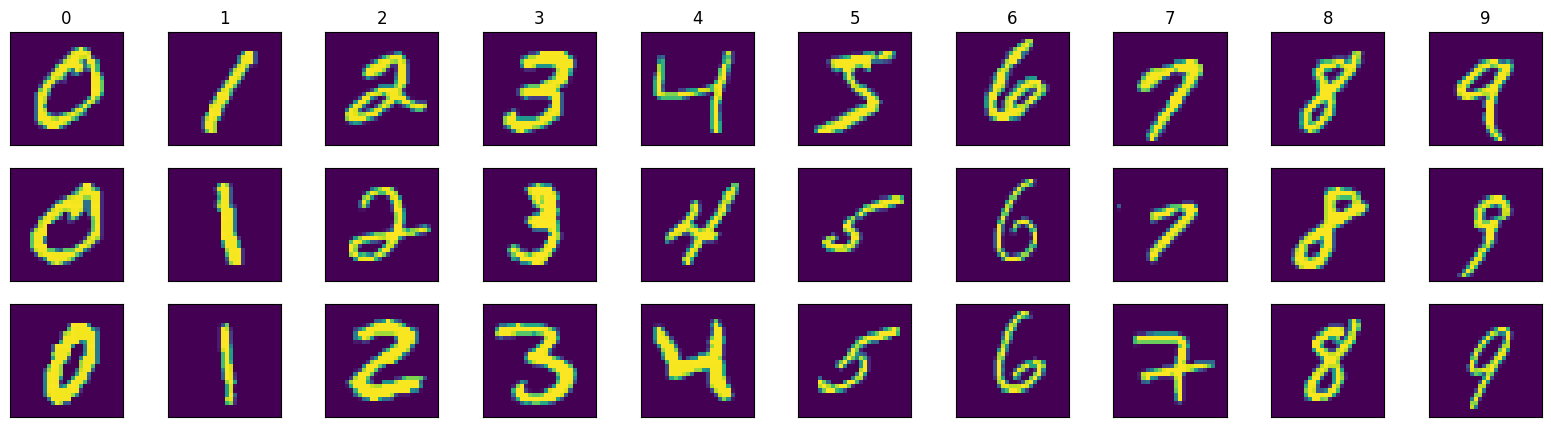

In [ ]:
# NOTE: visualize training dataset
_nrows = 3
fig, axes = plt.subplots(nrows=_nrows, ncols=10, figsize=(20, 5))
for lbl in range(10):
    for r in range(_nrows):
        ax = axes[r][lbl]
        ax.imshow(train_images[train_labels == lbl][r])
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])
        if r == 0:
            ax.set_title(f"{lbl}")

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels) -> None:
        if len(images) != len(labels):
            raise ValueError(f"Diffent number of images ({len(images)}) and labels ({len(labels)})!")

        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = (self.images[index] / 255.0).astype(np.float32)  # [0 .. 255] -> [0,1]

        # image = image[None, ...]  # NOTE: use this for conv models
        image = image.flatten()     # NOTE: use this for linear models
        label = self.labels[index]

        image = torch.from_numpy(image)  # float32 tensor
        label = torch.LongTensor([label])  # long tensor

        return image, label

In [ ]:
class MLP(nn.Module):
    def __init__(self, nin: int, nouts: List[int]) -> None:
        super().__init__()
        sizes = [nin] + nouts
        self.layers = nn.ModuleList([nn.Linear(sizes[i], sizes[i + 1]) for i in range(len(nouts))])
        self.n_layers = len(self.layers)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i != self.n_layers - 1:
                # x = torch.tanh(x)
                x = F.relu(x)
            # else:
            #     x = F.softmax(x, dim=1)
        return x


# to make sure that model parameters initialized like in micrograd example
def init_parameters(module):
    if isinstance(module, nn.Linear):
        module.weight = torch.nn.init.uniform_(module.weight, -1, 1)
        module.bias.data.fill_(0.0)

In [ ]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    model.train()

    losses = []
    accuracies = []

    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:
            x_batch = x_batch.to(device)
            y_true = y_true.squeeze(1).to(device)

            # TENSOR SHAPES:
            #    x_batch - [B, 28 * 28]
            #    y_true  - [B]
            #    y_pred  - [B, 10]

            # TODO: do a zero grad, DONE
            optimizer.zero_grad()

            y_pred = model(x_batch)

            # TODO: compute loss, DONE
            loss = criterion(y_pred, y_true)

            # TODO: do a backward propagation, DONE
            loss.backward()

            losses.append(loss.item())
            accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

            progress.set_postfix_str(f"loss {losses[-1]:.4f}")

            optimizer.step()

            progress.update(1)

    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }
    return logs


In [ ]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    model.eval()

    losses = []
    accuracies = []

    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        x_batch = x_batch.to(device)
        y_true = y_true.squeeze(1).to(device)

        # TENSOR SHAPES:
        #    x_batch - [B, 28 * 28]
        #    y_true  - [B]
        #    y_pred  - [B, 10]
        y_pred = model(x_batch)

        # TODO: compute loss, DONE
        loss = criterion(y_pred, y_true)

        losses.append(loss.item())
        accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }
    return logs

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}")

# TODO: play with architectures
model = MLP(nin=28 * 28, nouts=[500, 10])
model = model.to(device)  # NOTE: move model to device to speed up training using GPU parallelization
torch.manual_seed(42)     # NOTE: to handle model randomnes - fix seed before parameters initialization
model.apply(init_parameters)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

# NOTE: you can play with learning rate to increase convergence
#SGD = optim.SGD(model.parameters(), lr=1e-3, momentum=.9)

# NOTE: use this optimizer to see the difference in optimization compared with SGD
#Adam = optim.Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

Device - cpu
Number of trainable parameters - 397510


In [ ]:
# Use parametrs at one function
def test_model (batch_size, n_epochs, optimizer_type, lr):

  if optimizer_type == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=.9)
  elif optimizer_type == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

  train_loader = DataLoader(
    MNISTDataset(train_images, train_labels),
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    drop_last=True,
  )

  valid_loader = DataLoader(
    MNISTDataset(test_images, test_labels),
    batch_size=batch_size,
    shuffle=False,
    num_workers=os.cpu_count(),
    drop_last=False,
  )

  train_losses = []
  train_accuracies = []

  valid_losses = []
  valid_accuracies = []

  for ep in range(n_epochs):
    #print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device, verbose=False)
    train_losses.append(np.mean(train_logs["losses"]))
    train_accuracies.append(np.mean(train_logs["accuracies"]))
    #print("      loss:", train_losses[-1])
    #print("  accuracy:", train_accuracies[-1])


    valid_logs = evaluate(model, valid_loader, loss_fn, device, verbose=False)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_accuracies.append(np.mean(valid_logs["accuracies"]))
    #print("      loss:", valid_losses[-1])
    #print("  accuracy:", valid_accuracies[-1])

  fix, axes = plt.subplots(ncols=2, figsize=(15, 4))

  axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
  axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
  axes[0].legend(["train", "validation"])
  axes[0].set_title(f"Loss - Batch Size: {batch_size}, Epochs: {n_epochs}, \n Optimizer: {optimizer_type}, Learning rate: {lr}")
  axes[0].grid()

  axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
  axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
  axes[1].legend(["train", "validation"])
  axes[1].set_title(f"Accuracy - Batch Size: {batch_size}, Epochs: {n_epochs}, \n Optimizer: {optimizer_type}, Learning rate: {lr}")
  axes[1].grid()


Working on - Batch Size: 64, Epochs: 100, Optimizer: SGD, Learning rate: 0.001
Finished - Batch Size: 64, Epochs: 100, Optimizer: SGD, Learning rate: 0.001
Working on - Batch Size: 64, Epochs: 100, Optimizer: Adam, Learning rate: 0.001
Finished - Batch Size: 64, Epochs: 100, Optimizer: Adam, Learning rate: 0.001


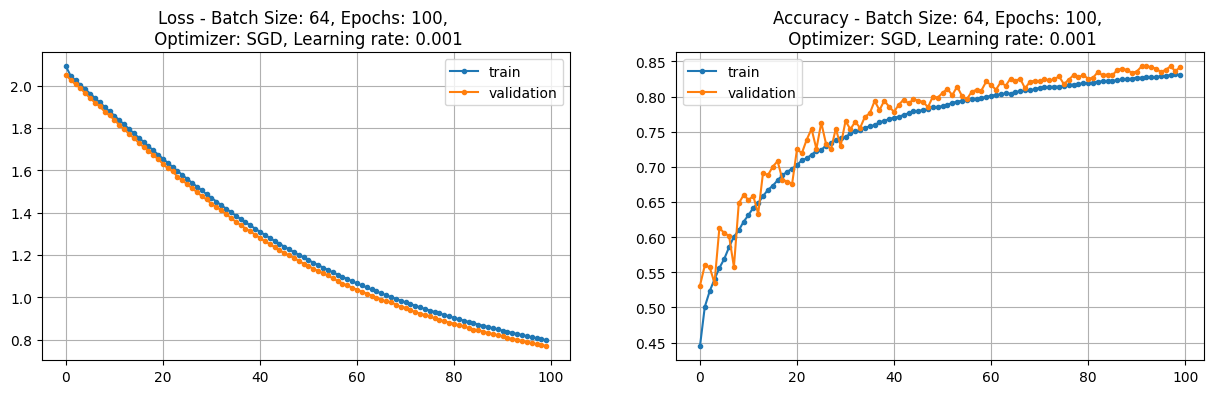

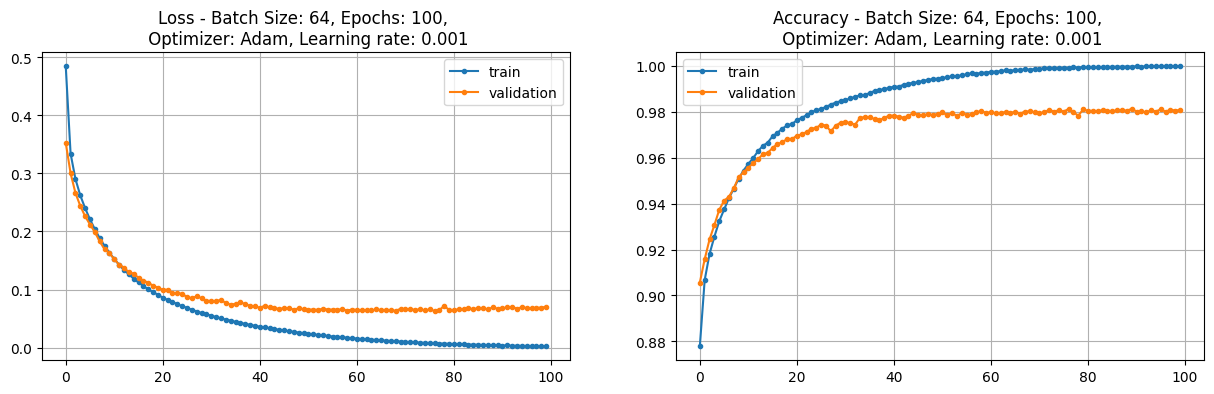

In [ ]:
# Choose optimizer
batch_size_list =[64]
n_epochs_list = [100]
optimizer_list = ["SGD", "Adam"]
lr_list = [1e-3]
for i in batch_size_list:
  for j in n_epochs_list:
    for k in optimizer_list:
      for t in lr_list:
        print(f"Working on - Batch Size: {i}, Epochs: {j}, Optimizer: {k}, Learning rate: {t}")
        test_model(i,j,k,t)
        print(f"Finished - Batch Size: {i}, Epochs: {j}, Optimizer: {k}, Learning rate: {t}")

Working on - Batch Size: 84, Epochs: 100, Optimizer: SGD, Learning rate: 0.001
Finished - Batch Size: 84, Epochs: 100, Optimizer: SGD, Learning rate: 0.001
Working on - Batch Size: 44, Epochs: 100, Optimizer: SGD, Learning rate: 0.001
Finished - Batch Size: 44, Epochs: 100, Optimizer: SGD, Learning rate: 0.001


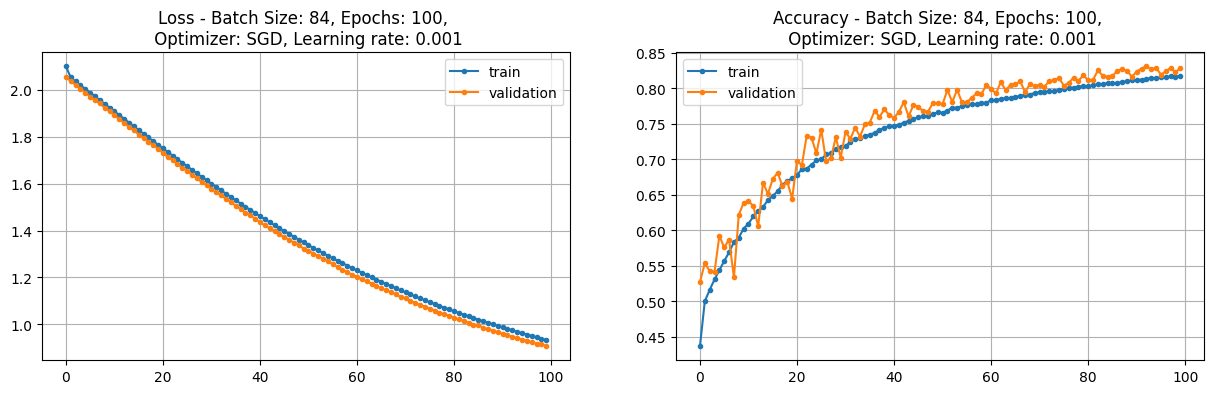

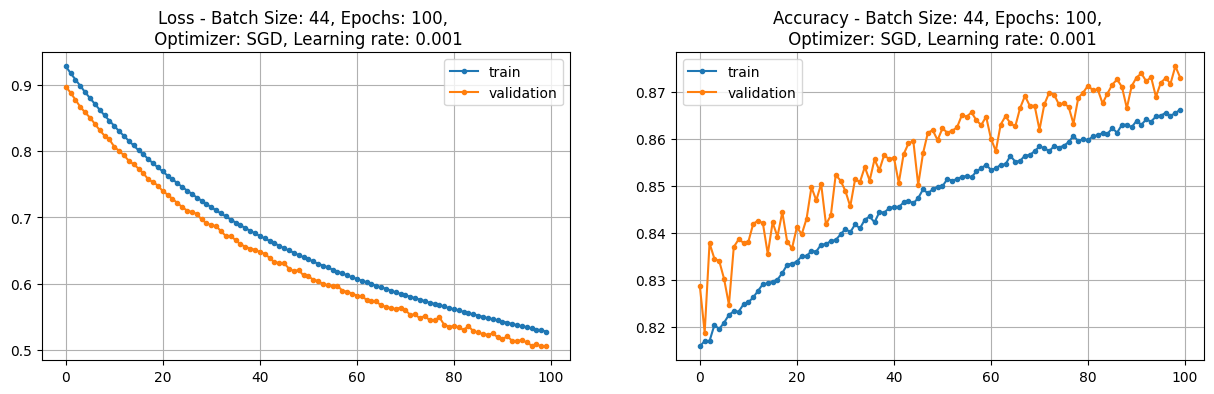

In [ ]:
# Choose batch_size
batch_size_list =[84, 44]
n_epochs_list = [100]
optimizer_list = ["SGD"]
lr_list = [1e-3]
for i in batch_size_list:
  for j in n_epochs_list:
    for k in optimizer_list:
      for t in lr_list:
        print(f"Working on - Batch Size: {i}, Epochs: {j}, Optimizer: {k}, Learning rate: {t}")
        test_model(i,j,k,t)
        print(f"Finished - Batch Size: {i}, Epochs: {j}, Optimizer: {k}, Learning rate: {t}")

Working on - Batch Size: 64, Epochs: 100, Optimizer: SGD, Learning rate: 0.01
Finished - Batch Size: 64, Epochs: 100, Optimizer: SGD, Learning rate: 0.01
Working on - Batch Size: 64, Epochs: 100, Optimizer: SGD, Learning rate: 0.0001
Finished - Batch Size: 64, Epochs: 100, Optimizer: SGD, Learning rate: 0.0001


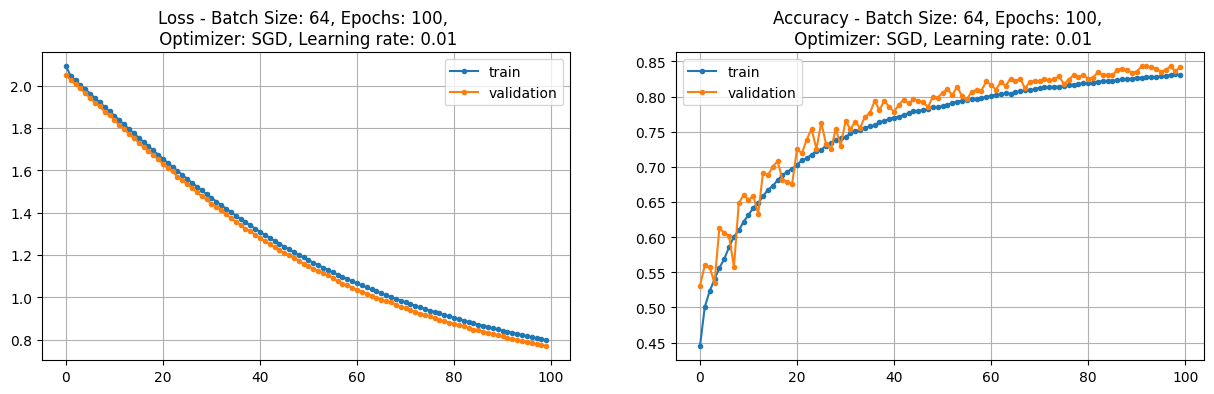

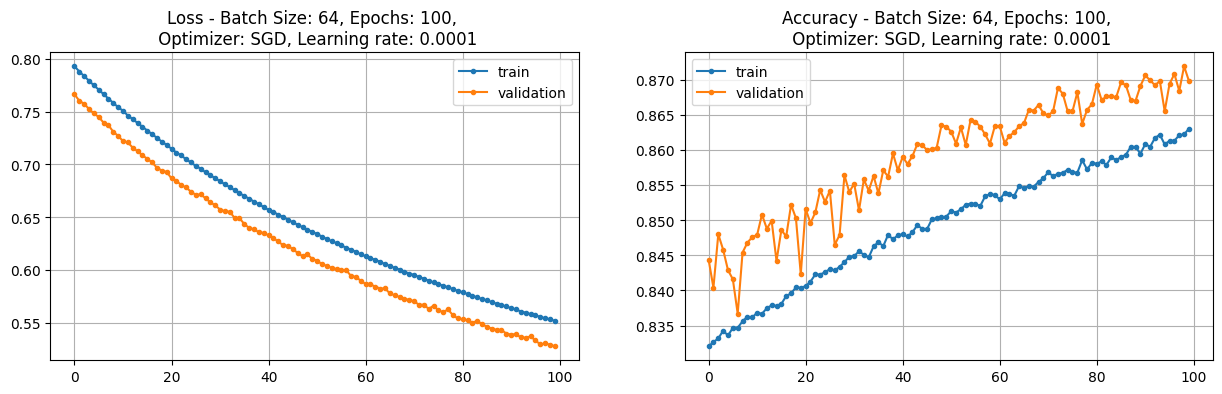

In [ ]:
# Choose lr
batch_size_list =[64]
n_epochs_list = [100]
optimizer_list = ["SGD"]
lr_list = [1e-2,1e-4]
for i in batch_size_list:
  for j in n_epochs_list:
    for k in optimizer_list:
      for t in lr_list:
        print(f"Working on - Batch Size: {i}, Epochs: {j}, Optimizer: {k}, Learning rate: {t}")
        test_model(i,j,k,t)
        print(f"Finished - Batch Size: {i}, Epochs: {j}, Optimizer: {k}, Learning rate: {t}")

Working on - Batch Size: 64, Epochs: 150, Optimizer: SGD, Learning rate: 0.001
Finished - Batch Size: 64, Epochs: 150, Optimizer: SGD, Learning rate: 0.001


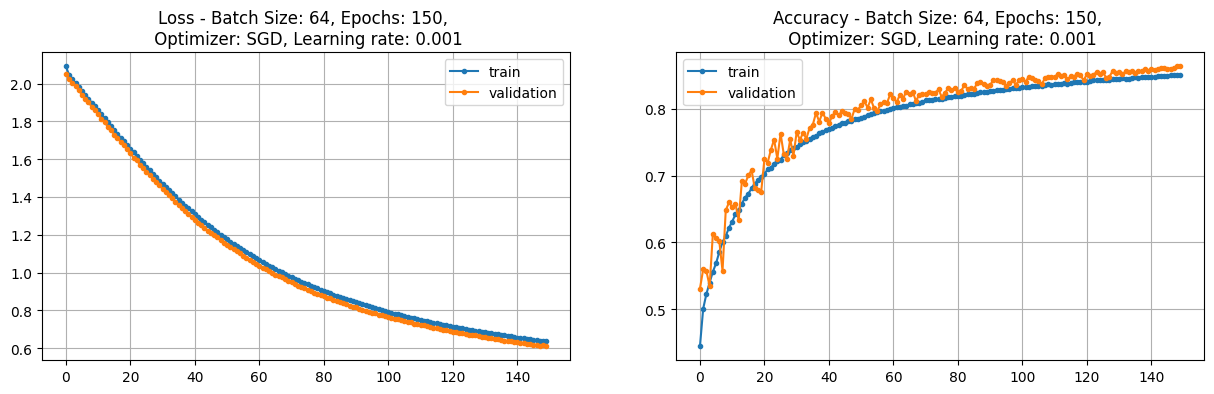

In [ ]:
# Choose n_epochs
batch_size_list =[64]
n_epochs_list = [150]
optimizer_list = ["SGD"]
lr_list = [1e-3]
for i in batch_size_list:
  for j in n_epochs_list:
    for k in optimizer_list:
      for t in lr_list:
        print(f"Working on - Batch Size: {i}, Epochs: {j}, Optimizer: {k}, Learning rate: {t}")
        test_model(i,j,k,t)
        print(f"Finished - Batch Size: {i}, Epochs: {j}, Optimizer: {k}, Learning rate: {t}")

Working on - Batch Size: 64, Epochs: 200, Optimizer: SGD, Learning rate: 0.001
Finished - Batch Size: 64, Epochs: 200, Optimizer: SGD, Learning rate: 0.001


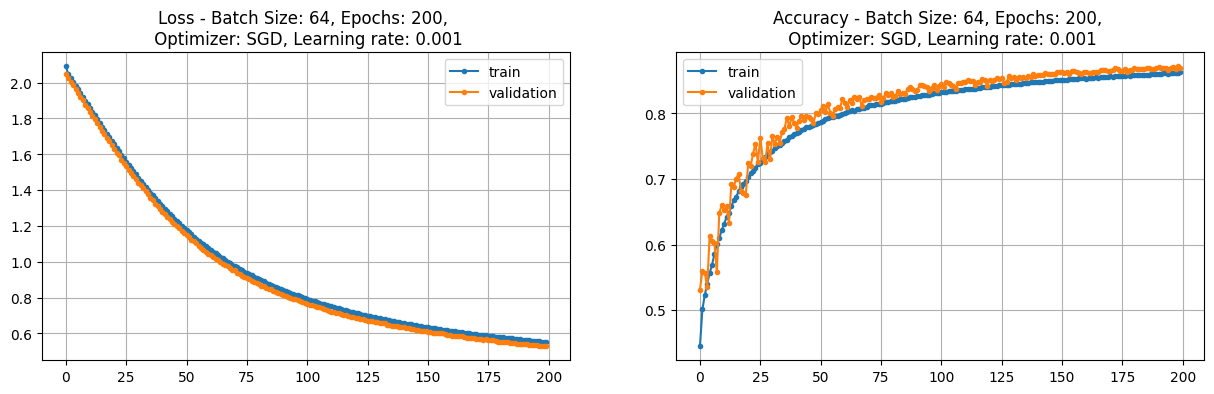

In [ ]:
# Change n_epochs
batch_size_list =[64]
n_epochs_list = [200]
optimizer_list = ["SGD"]
lr_list = [1e-3]
for i in batch_size_list:
  for j in n_epochs_list:
    for k in optimizer_list:
      for t in lr_list:
        print(f"Working on - Batch Size: {i}, Epochs: {j}, Optimizer: {k}, Learning rate: {t}")
        test_model(i,j,k,t)
        print(f"Finished - Batch Size: {i}, Epochs: {j}, Optimizer: {k}, Learning rate: {t}")

**TODO:**


Write here about model architectures you've tried, it's metrics, and intuition why something worked and something don't.

I explored different values for the following parameters:

*   Batch Size
*   Epochs
*   Optimizer
*   Learning rate

***Batch Size*** is the number of data points used in each iteration of model
training. By experimenting with batch sizes of 44, 64, 84, a batch size of 64 provided the most efficiency and model performance.

***Epochs*** represent the number of times the entire dataset is processed during training. I ran experiments with 100, 150, 200 epochs. The model benefits from additional training iterations, with 200 epochs showing a better result.

 ***Optimizer***influences the model's ability to converge and find optimal parameter values. I have compared the SGD and Adam optimisers. SGD's effectiveness in finding the global minimum for our model architecture made it the preferred choice.

***Learning rate*** is a hyperparameter that controls the size of the steps taken during optimization. I experimented with learning rates of 1e-2, 1e-3, and 1e-4 to understand their impact on model accuracy. The results showed that learning rates of 1e-3 and 1e-4 gave the most stable convergence and superior performance.